# Lossless JPEG Experimentation

In [1]:
import pathlib

import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval

import PIL
import pillow_jpls

from overlappy.util import color_lat_lon_axes
from mocksipipeline.util import stack_components

ImportError: dlopen(/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/pillow_jpls/_pycharls.so, 0x0002): symbol not found in flat namespace (__ZN3fmt2v97vformatENS0_17basic_string_viewIcEENS0_17basic_format_argsINS0_20basic_format_contextINS0_8appenderEcEEEE)

In [3]:
data_dir = pathlib.Path('data/')

In [13]:
files = data_dir.glob('overlappogram-ar-photons-order=*.fits')

In [14]:
overlappogram = stack_components(sorted(files), wcs_index=2)

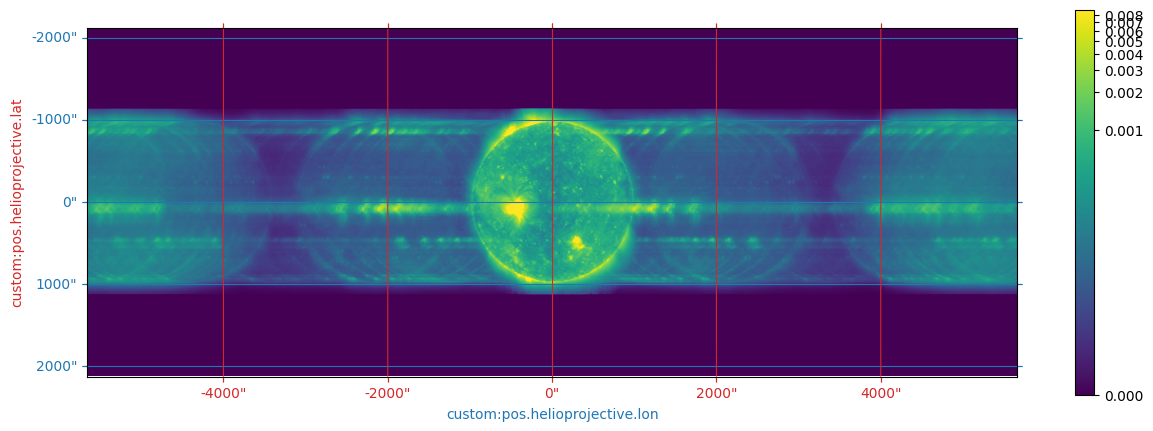

In [19]:
fig = plt.figure(figsize=(15,5))
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(overlappogram[0].data)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=overlappogram[0].wcs)
overlappogram[0].plot(
    axes=ax,
    norm=norm,
    data_unit='photon / (pix s)',
    cmap='viridis',
)
color_lat_lon_axes(ax)
plt.colorbar()

In [ ]:
image_pillow = 